In [1847]:
from src.data_loader import PVDataLoader
from src import data_loader as dl
import torch
import numpy as np

In [1935]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

In [1936]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

_, y = loader.get_time_series()
time = torch.arange(0, len(y))
t_train, y_train, t_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)

==> Loading data
==> Loaded data in: 0 m : 12 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [1937]:
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL)
periodic_train, _, periodic_test, _ = dl.train_test_split(periodic_time, y, n_hours=N_HOURS_PRED)

In [1938]:
INTERVAL = 10

# filter data by interval 
t_train = t_train[::INTERVAL]
y_train = y_train[::INTERVAL]
periodic_train = periodic_train[::INTERVAL]

print('t_train', t_train.shape)
print('y_train', y_train.shape)
print('periodic_train', periodic_train.shape)



t_train torch.Size([46])
y_train torch.Size([46, 11])
periodic_train torch.Size([46])


# Approximate Latent Force Model

In [1939]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from os import path
from alfi.plot import Plotter1d
from lfm.dataset import PV_LFM_Dataset

In [1940]:
num_outputs = 1
num_latents = 1
num_inducing = 100
dataset = PV_LFM_Dataset(num_outputs=num_outputs, 
                         m_observed=y_train[:, :num_outputs],
                         f_observed=periodic_train, 
                         train_t=t_train,
                         variance= 0.1 * torch.ones(num_outputs))

In [1941]:
from alfi.models.variational_lfm import VariationalLFM
from alfi.configuration import VariationalConfiguration
import lfm

In [1942]:
from abc import abstractmethod

import torch
import gpytorch
from torch.distributions import Distribution
from torchdiffeq import odeint
from gpytorch.lazy import DiagLazyTensor
from alfi.utilities.torch import is_cuda

class OrdinaryLFM(VariationalLFM):
    """
    Variational approximation for an LFM based on an ordinary differential equation (ODE).
    Inheriting classes must override the `odefunc` function which encodes the ODE.
    """

    def __init__(self,
                 num_outputs,
                 gp_model,
                 config: VariationalConfiguration,
                 initial_state=None,
                 **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.nfe = 0
        
        if initial_state is None:
            self.initial_state = torch.zeros(torch.Size([self.num_outputs, 1]), dtype=self.dtype)
        else:
            self.initial_state = initial_state

    @property
    def initial_state(self):
        return self._initial_state

    @initial_state.setter
    def initial_state(self, value):
        value = value.cuda() if is_cuda() else value
        self._initial_state = value

    def forward(self, t, step_size=1e-1, **kwargs):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
      
        self.nfe = 0

        # get initial state
        h0 = self.initial_state
        h0 = h0.unsqueeze(0).repeat(torch.Size([self.config.num_samples, 1]))  
        
        t = torch.arange(0, t.size(0)).float()
        
        # sample time points to use for ODE solver
        t_f = torch.arange(0, t.size(0)+ step_size/3, step_size/3)
        
        q_f = self.gp_model(t_f)

        self.latent_samples = q_f.rsample(torch.Size([self.config.num_samples]))

        self.t_index = 0
        self.last_t = t_f.min() - 1
        
        h_samples = odeint(func=self.odefunc, 
                           y0=h0, 
                           t=t, 
                           method='rk4',
                           options={'step_size': step_size})
        
        # remove last dimension of h samples
        h_samples = h_samples

        dist = self.build_output_distribution(h_samples)
        
        return dist
    
    # TODO fix covariance matrix to be PSD always and vectorize (maybe use easier approximations)
    def construct_cov_mat(self, h_centered, jitter=1e-2, add_jitter=True):
       
        time, _, num_tasks = h_centered.shape # (time, samples, num_tasks)
        h_covar = torch.zeros(size=(num_tasks, time, time))
        
        for i in range(num_tasks):   
            h = h_centered[:, :, i] 
            if add_jitter:                
                cov = torch.matmul(h, h.t())  + torch.eye(time) * jitter
            else:
                cov = torch.matmul(h, h.t())
            h_covar[i] = cov
        
        return h_covar
   

    def build_output_distribution(self, h_samples) -> Distribution:
        """
        Parameters:
            h_samples: shape (time, samples, num_tasks)
        """        
        h_mean = h_samples.mean(dim=1) # (time, num_tasks)
        h_centered = h_samples - h_mean.unsqueeze(1) # (time, samples, num_tasks)
        
        h_covar = self.construct_cov_mat(h_centered, jitter=1e-1) # (num_tasks, time, time)
        
        if h_covar.shape[0] == 1:
            h_covar = h_covar.squeeze(0) # (time x time)
            h_mean = h_mean.squeeze(-1) # (time)           
            
            return gpytorch.distributions.MultivariateNormal(h_mean, h_covar)
        else:
            batch_mvn = gpytorch.distributions.MultivariateNormal(h_mean, h_covar)
            dist = gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=1)

        return dist    
  
    @abstractmethod
    def odefunc(self, t, h, **kwargs):
        """
        Parameters:
            h: shape (num_samples, num_outputs, 1)
        """
        pass


In [1943]:
from torch.nn import Softplus 

class PhotovoltaicLFM(OrdinaryLFM):
    def __init__(self, 
                num_outputs : int, 
                gp_model : gpytorch.models.ApproximateGP, # multi-task GP 
                config: gpytorch.variational.VariationalStrategy,
                dataset : lfm.dataset.LFMDataset,
                nonlinear : bool = False,
                **kwargs):
        
        super().__init__(num_outputs=num_outputs, 
                         gp_model=gp_model, 
                         config=config, 
                         initial_state=dataset.data[0][1][0], 
                         **kwargs)
        
        self.raw_initial_pv = dataset.data[0][1][0]
        self.nonlinear = nonlinear
        self.true_f = dataset.f_observed
        # TODO add constraints to decay and growth
        self.raw_decay = torch.nn.Parameter(torch.ones(num_outputs)*0.1)
        self.raw_growth = torch.nn.Parameter(torch.ones(num_outputs)*0.1)

        if nonlinear:
            self.softplus = Softplus()
        
    @property
    def initial_pv(self):
        return self.raw_initial_pv
    
    @initial_pv.setter
    def initial_pv(self, value):
        value = value.cuda() if is_cuda() else value
        self.raw_initial_pv = value
    
    def initial_state(self):
        return self.initial_pv
    
    @property
    def decay(self):
        return self.raw_decay
    
    @decay.setter
    def decay(self, value):
        value = value.cuda() if is_cuda() else value
        self.raw_decay = value
    
    @property
    def growth(self):
        return self.raw_growth
    
    @growth.setter
    def growth(self, value):
        value = value.cuda() if is_cuda() else value
        self.raw_growth = value
    
    def G(self, f):
        if self.nonlinear:
            return self.softplus(f) #.repeat(1, self.num_outputs, 1)
        else:
            return f

    def odefunc(self, t, h):
        # TODO very possibly wrong for modeling PV data

        latents = self.latent_samples[:, self.t_index]
        f = self.G(latents).view(self.config.num_samples, self.num_outputs)
        
        fh = f * h
        dh = self.growth * (fh)  - h * self.decay

        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        return dh 


In [1944]:
class LFMTrainer:
    """ 
    Trainer for PV LFM model.

    Args:
        model (nn.Module): LFM model
        optimizer (torch.optim): optimizer
        dataset (LFMDataset): dataset
        step_size (float): step size for ODE solver
    """

    def __init__(self, 
                 model : PhotovoltaicLFM, 
                 optimizer : torch.optim.Optimizer, 
                 dataset : PV_LFM_Dataset, 
                 step_size : float):
        
        self.model = model
        self.dataset = dataset
        self.step_size = step_size
        self.optim = optimizer
    
    def train(self, n_iter : int, verbose : bool = False, freq : int = 10):
        """
        Train the model for a specified number of epochs.

        Args:
            epochs (int): number of epochs
            lr (float): learning rate
            optim (torch.optim.Optimizer): optimizer
            verbose (bool): whether to print training progress
        """
        train_t = self.dataset[0][0]
        train_y = self.dataset[0][1]

        elbo = gpytorch.mlls.VariationalELBO(self.model.gp_model.likelihood, self.model.gp_model, num_data=len(train_y))
    
        print_freq = n_iter // freq

        for i in range(n_iter):
            
            self.optim.zero_grad()
            output = self.model(train_t, step_size=self.step_size)
      
            loss = -elbo(output, train_y)
            loss.backward()
            self.optim.step()
            
            if verbose and (i+1) % print_freq == 0:
                print(f'Epoch {i+1}/{n_iter}: loss {loss.item():.3f}')
            

In [1945]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              ScaleKernel, 
                              AdditiveKernel)
# TODO add a prior to the period in periodic

matern_base = MaternKernel(nu=3/2, 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1)
                            )
product_kernel_matern_periodic = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive()
                            )

quasi_periodic_matern = AdditiveKernel(product_kernel_matern_periodic, scaled_matern)

In [1949]:
from src.models import ApproximateGPBaseModel
from src.beta_likelihood import BetaLikelihood_MeanParametrization

# TODO consider what GP model to use, not neccessarily best to use beta likelihood for this
jitter = 1e-2
gp_config = {
            'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': t_train.size(0),
            'mean_init_std': 1,
            }
gp_inputs = {
            'X': dataset.t_observed, 
            'y': dataset.data[0][1], 
            'mean_module': gpytorch.means.ZeroMean(),
            'covar_module': scaled_matern,
            'likelihood': gpytorch.likelihoods.GaussianLikelihood(),
            # 'num_latents' : num_latents,
            # 'variational_strategy': 'mt_indep',
            'config': gp_config,
            'jitter': jitter
}
gp_model = ApproximateGPBaseModel(**gp_inputs)

In [1950]:
from alfi.configuration import VariationalConfiguration
config = VariationalConfiguration(num_samples=10)

# TODO seperate variational and non-variational parameters

lfm_model = PhotovoltaicLFM(num_outputs=1,
                            gp_model=gp_model,
                            config=config,
                            dataset=dataset,
                            nonlinear=True)

lfm_trainer = LFMTrainer(model=lfm_model,
                         optimizer=torch.optim.Adam(lfm_model.parameters(), lr=0.2),
                         dataset=dataset,
                         step_size=3)

In [1951]:
lfm_trainer.train(n_iter=500, verbose=True, freq=10)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 36 is not positive-definite).

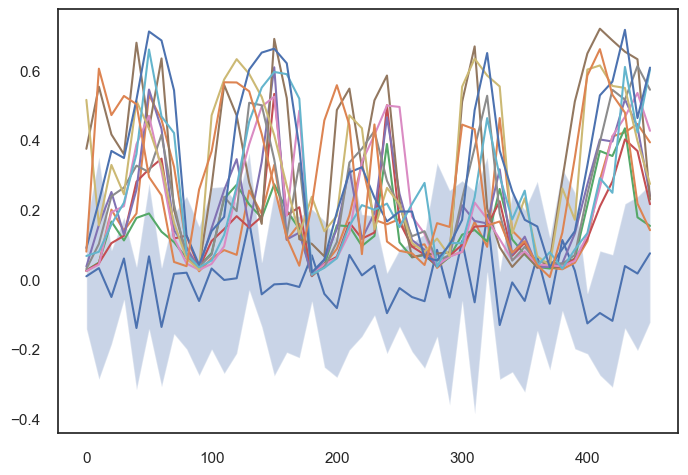

In [ ]:
with torch.no_grad():
    q_f = lfm_model(t_train.float())
    samples = q_f.rsample(torch.Size([30]))

mean = samples.mean(dim=0)
var = samples.var(dim=0)
plt.plot(t_train, mean, label='Mean')
plt.fill_between(t_train, mean - 2*var, mean + 2*var, alpha=0.3, label='2 std')
plt.plot(t_train, y_train, label='True');





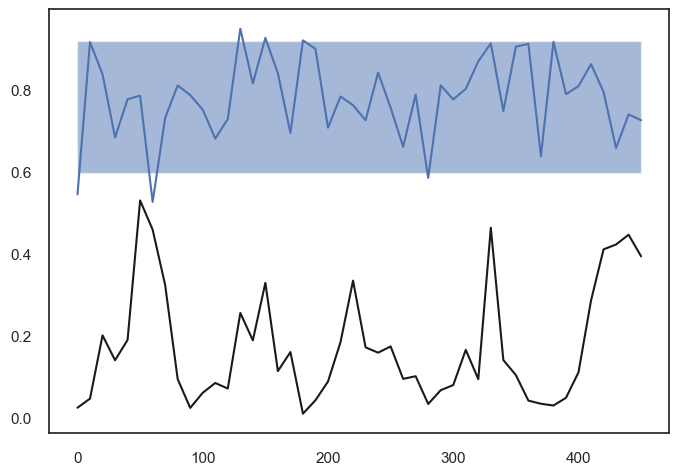

In [ ]:
import numpy as np
mean = f_samples.mean(dim=1).mean(dim=0).numpy()
lower, upper = np.quantile(mean, q=[0.05, 0.95], axis=0)

plt.plot(t_train, mean)
plt.fill_between(t_train, lower, upper, alpha=0.5)

plt.plot(t_train, y_train[:, 0].numpy(), 'k')

